In [1]:
import os
import re
import time
from datetime import datetime, time, timedelta
from urllib.parse import parse_qs, urlparse

import googlemaps
import numpy as np
import pandas as pd
import statsmodels.api as sm
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz, process
from matplotlib import pyplot as plt
from selenium import webdriver
from selenium.common.exceptions import (
    ElementNotInteractableException,
    NoSuchElementException,
)
from selenium.webdriver.common.by import By

# 1.0 Webscrape
## Selenium + BeautifulSoup

In [2]:
class SpareRoomScraper:
    def __init__(self, browser, n_pages: int):
        self.browser = browser
        self.n_pages = n_pages

    def tidy_adverts(self):
        adverts = self.scrape_pages()
        adverts["rent_amt"] = adverts["price"].apply(lambda x: scraper.tidy_price(x))
        adverts[["area", "pcd"]] = adverts["location"].apply(
            lambda x: pd.Series(self.tidy_pcd(x))
        )
        adverts["location_"] = (
            adverts["location"].str.replace("(", "").str.replace(")", "")
        )
        adverts["location_"] = adverts["location_"].apply(self.remove_dup_str)

        return adverts.reset_index()

    def remove_dup_str(self, text):
        words = text.split()
        unique_words = list(dict.fromkeys(words))
        return " ".join(unique_words)

    def tidy_pcd(self, text):
        match = re.match(r"(.*?)\s*\((.*?)\)\s*$", text)
        if match:
            return match.group(1).strip(), match.group(2).strip()
        return text, ""

    def tidy_price(self, rent_string):
        rent_string_1 = (
            rent_string.replace("pcm", "")
            .replace("pw", "")
            .strip()
            .replace("£", "")
            .replace(",", "")
        )
        if "-" in rent_string_1:
            low, high = map(float, rent_string_1.split("-"))
            if "pw" in rent_string:
                return ((low + high) / 2 * 52) / 12
            else:
                return (low + high) / 2
        else:
            if "pw" in rent_string:
                return float(rent_string_1) * 52 / 12
            else:
                return float(rent_string_1)

    def scrape_pages(self):
        k = 3  # integer
        random_number = min(np.random.gamma(shape=k, scale=2 / k, size=1)[0] + 3, 5)

        master_df = None
        for i in range(0, self.n_pages):
            self.close_register_popup()
            listings = self.scrape_listings()
            listings_df = pd.DataFrame(listings)
            if master_df is None:
                master_df = listings_df
            else:
                master_df = pd.concat([master_df, listings_df])

            button = self.browser.find_element(By.ID, "paginationNextPageLink")
            button.click()
            time.sleep(random_number)
        return master_df

    def scrape_listings(self):
        self.accept_cookies()
        html_source = self.browser.page_source
        soup = BeautifulSoup(html_source, "html.parser")

        listings = []

        articles = soup.find_all("article", class_="panel-listing-result listing-bold")
        featured_articles = soup.find_all(
            "article", class_="panel-listing-result listing-featured"
        )
        early_birds = soup.find_all(
            "article", class_="panel-listing-result listing-free"
        )

        # print(f"Number of featured articles: {len(featured_articles)}")

        all_articles = articles + early_birds  # + featured_articles

        for article in all_articles:
            listing = self.extract_listing_info(article)
            listings.append(listing)

        return listings

    def accept_cookies(self):
        try:
            button = self.browser.find_element(By.ID, "onetrust-accept-btn-handler")
            button.click()
        except (NoSuchElementException, ElementNotInteractableException):
            pass

    def close_register_popup(self):
        try:
            button = self.browser.find_element(By.ID, "reg_close")
            button.click()
        except (NoSuchElementException, ElementNotInteractableException):
            pass

    def extract_listing_info(self, article):
        title = article.find("h2").text.strip()
        price = article.find("strong", class_="listingPrice").text.strip()
        location = article.find("span", class_="listingLocation").text.strip()
        description = article.find("p", class_="description").text.strip()
        bills = article.find("em", class_="listingPriceDetails").text.strip()
        try:
            early_bird = (
                article.find("span", class_="earlyBird status")
                .find("span", class_="tooltip_item")
                .text.strip()
            )
        except AttributeError:
            early_bird = ""
        availability = article.find_all("strong")
        if len(availability) > 1:
            availability = availability[2].text.strip()
        href = article.find("a")["href"]

        result_id = self.extract_id_from_url(href)

        return {
            "title": title,
            "price": price,
            "location": location,
            "description": description,
            "availability": availability,
            "bills": bills,
            "early_bird": early_bird,
            "href": href,
            "id": result_id,
        }

    def extract_id_from_url(self, url):
        parsed_url = urlparse(url)
        query_params = parse_qs(parsed_url.query)

        flatshare_id = query_params.get("flatshare_id", [None])[0]
        fad_id = query_params.get("fad_id", [None])[0]

        return flatshare_id if flatshare_id else fad_id

In [5]:
#### access URL in browser
url = "https://www.spareroom.co.uk/flatshare/?search_id=1324225904&mode=list"  # has garden

browser = webdriver.Chrome()
browser.get(url)

In [6]:
scraper = SpareRoomScraper(browser, n_pages=25)

adverts = scraper.tidy_adverts()
adverts.head(2)

,index,title,price,location,description,availability,bills,early_bird,href,id,rent_amt,area,pcd,location_
0,0,🎋HOUSE WhiteChapel/StepneyGreen/QMUL,£720-£850 pcm,Stepney Green (E1),HOUSE WhiteChapel/StepneyGreen/QMUL\n\nHOUSE w...,Available 24th Sep,Bills inc.,,/flatshare/fad_click.pl?fad_id=17478301&search...,17478301,785.0,Stepney Green,E1,Stepney Green E1
1,1,"🚨 River front, double room - gym -swimming",£225-£270 pw,Canary Wharf (E14),Double room for single use only\nDouble room w...,Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17212833,1072.5,Canary Wharf,E14,Canary Wharf E14


In [8]:
adverts.shape

(275, 14)

# 2.0 Deprivation data

## 2.1 MSOA data

In [9]:
#### shows no. deprived households in area

msoa = pd.read_csv(
    "TS011-2021-6-filtered-2024-09-19T20_52_48Z.csv", engine="python"
).rename(
    columns={
        "Middle layer Super Output Areas Code": "msoa_code",
        "Middle layer Super Output Areas": "msoa_name",
        "Household deprivation (6 categories) Code": "deprivation_code",
        "Household deprivation (6 categories)": "deprivation_category",
        "Observation": "count",
    }
)
msoa.loc[msoa["msoa_code"] == "E02000640", :]

,msoa_code,msoa_name,deprivation_code,deprivation_category,count
3642,E02000640,Lambeth 023,-8,Does not apply,0
3643,E02000640,Lambeth 023,1,Household is not deprived in any dimension,2267
3644,E02000640,Lambeth 023,2,Household is deprived in one dimension,1033
3645,E02000640,Lambeth 023,3,Household is deprived in two dimensions,398
3646,E02000640,Lambeth 023,4,Household is deprived in three dimensions,95
3647,E02000640,Lambeth 023,5,Household is deprived in four dimensions,13


In [10]:
# Create a deep copy of the 'msoa' dataframe to avoid modifying the original
msoa_1 = msoa.copy(deep=True)

# Calculate the proportion of each within its MSOA
msoa_1["total"] = msoa.groupby("msoa_code")["count"].transform(lambda x: x.sum())
msoa_1["prop"] = msoa.groupby("msoa_code")["count"].transform(lambda x: x / x.sum())

# Filter Household is not deprived in any dimension
msoa_1 = msoa_1.loc[msoa.deprivation_code == 1, :]

# Eg.
msoa_1.loc[msoa_1.msoa_code == "E02000640", :]

,msoa_code,msoa_name,deprivation_code,deprivation_category,count,total,prop
3643,E02000640,Lambeth 023,1,Household is not deprived in any dimension,2267,3806,0.595638


In [11]:
### Match msoa to full neighbourhood name
msoa_name = pd.read_csv("MSOA-Names-2.2.csv", engine="python")
msoa_2 = pd.merge(
    msoa_1,
    msoa_name.loc[:, ["msoa21cd", "msoa21hclnm"]],
    right_on=["msoa21cd"],
    left_on=["msoa_code"],
    how="left",
)
msoa_2.loc[msoa_2.msoa_code == "E02000640", :]
# msoa_2.loc[msoa_2.msoa_name.str.startswith('Lambeth'), :]

,msoa_code,msoa_name,deprivation_code,deprivation_category,count,total,prop,msoa21cd,msoa21hclnm
607,E02000640,Lambeth 023,1,Household is not deprived in any dimension,2267,3806,0.595638,E02000640,Clapham Park West


## 2.2 Postcode look-up

In [12]:
# Match msoa to postcode - many to one relationship
postcode = pd.read_csv("NSP21CL_NOV23_UK_LU.csv", engine="python", encoding="latin1")
msoa_3 = pd.merge(
    msoa_2,
    postcode.loc[:, ["msoa21cd", "pcd7", "soac11nm", "lacnm"]],
    on="msoa21cd",
    how="left",
)
msoa_3["pcd_area"] = msoa_3.pcd7.str.slice(0, 4).str.strip()
# msoa_3.loc[msoa_3.msoa_code == 'E02000640', :]
# msoa_3.loc[msoa_3['msoa21hclnm'].str.contains('Stratford') & msoa_3.pcd7.str.contains('E15'), :]

In [13]:
msoa_4 = (
    msoa_3.groupby(["msoa21cd", "msoa21hclnm"])
    .agg(
        {
            "pcd_area": "first",
            "pcd7": "first",
            "soac11nm": "first",
            "prop": ["mean", "std", "count"],
        },
    )
    .reset_index()
)

msoa_4.columns = [f"{col[0]}_{col[1]}" for col in msoa_4.columns]
msoa_4["location_"] = msoa_4["msoa21hclnm_"] + " " + msoa_4["pcd_area_first"]
# msoa_4.loc[(msoa_4.pcd_area_first == "E15"), :]

In [15]:
#### exact matches

adverts_1 = pd.merge(
    adverts, msoa_4, left_on="location_", right_on="location_", how="inner"
)
adverts_1.shape

(57, 22)

## 3.0 Merge Deprivation Score
- adverts: scraped SpareRoom adverts
- msoa_4: msoa-level deprivation with postcode look-up

In [24]:
def fuzzy_match_column(df1, df2, col1, col2, new_col_name="match", threshold=75):
    def find_best_match(row):
        combined_str = f"{row[col1]} {row[col2]}"
        matches = df2.apply(
            lambda x: fuzz.token_set_ratio(combined_str, f"{x[col1]} {x[col2]}"), axis=1
        )
        best_match_idx = matches.idxmax()
        best_match_score = matches[best_match_idx]
        if best_match_score > threshold:
            return df2.loc[best_match_idx, col1]  # or col2, depending on which you want
        return None

    df1[new_col_name] = df1.apply(find_best_match, axis=1)
    return df1

In [25]:
adverts_fuzzy = fuzzy_match_column(
    adverts, msoa_4, "location_", "location_", new_col_name="match"
)
adverts_1 = pd.merge(
    adverts_fuzzy, msoa_4, left_on="match", right_on="location_", how="inner"
)

print(f"""Fuzzy matched {adverts_1.shape[0]} out of {adverts.shape[0]}""")

Fuzzy matched 227 out of 275


In [26]:
adverts_fuzzy[["location_", "match"]].head(5)

,location_,match
0,Stepney Green E1,Stepney Green E1
1,Canary Wharf E14,Canary Wharf E14
2,London SW11,None
3,Archway N19,Archway East N19
4,Upton E7,Upton Park E13


In [27]:
adverts_1.dtypes

index               int64
title              object
price              object
location           object
description        object
availability       object
bills              object
early_bird         object
href               object
id                 object
rent_amt          float64
area               object
pcd                object
location__x        object
match              object
msoa21cd_          object
msoa21hclnm_       object
pcd_area_first     object
pcd7_first         object
soac11nm_first     object
prop_mean         float64
prop_std          float64
prop_count          int64
location__y        object
dtype: object

## 3.1 Test fit

In [28]:
X = adverts_1["prop_mean"]
y = adverts_1["rent_amt"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               rent_amt   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.231
Date:                Mon, 23 Sep 2024   Prob (F-statistic):              0.268
Time:                        19:41:33   Log-Likelihood:                -1501.7
No. Observations:                 227   AIC:                             3007.
Df Residuals:                     225   BIC:                             3014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        935.9827     57.518     16.273      0.0

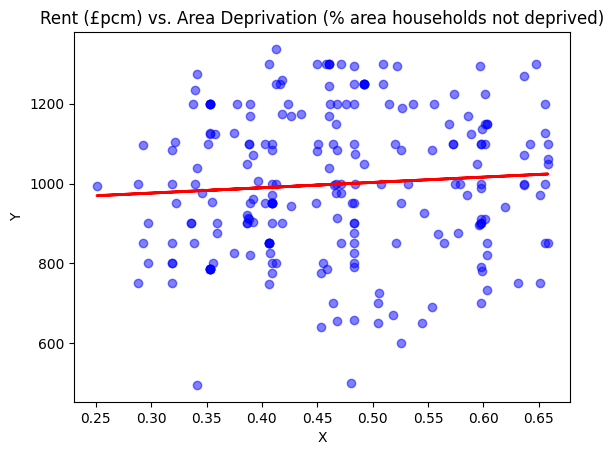

In [31]:
plt.scatter(adverts_1["prop_mean"], adverts_1["rent_amt"], color="blue", alpha=0.5)
plt.plot(adverts_1["prop_mean"], model.predict(X), color="red", linewidth=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Rent (£pcm) vs. Area Deprivation (% area households not deprived)")
plt.show()

## 4.0 Integrate MAPS API

## Travel time to target

In [32]:
API = ""
gmaps = googlemaps.Client(key=API)

In [41]:
def calculate_travel_times(df, start_col, end_location):
    # maps API
    gmaps = googlemaps.Client(key=API)

    # Set departure time to 8:30 tomorrow (check working day)
    departure_time = datetime.combine(datetime.today() + timedelta(days=1), time(8, 30))

    def get_travel_time(start):
        try:
            result = gmaps.directions(
                start, end_location, mode="transit", departure_time=departure_time
            )

            if result and len(result) > 0:
                return (
                    result[0]["legs"][0]["duration"]["value"] / 60
                )  # Convert seconds to minutes
            else:
                return None
        except Exception as e:
            print(f"Error calculating travel time for {start}: {str(e)}")
            return None

    # Apply the function to the start location column
    df.loc[:, "travel_time_minutes"] = df[start_col].apply(get_travel_time)

    return df


# example
df = pd.DataFrame({"start_location": ["Clapham SW4", "London Bridge", "Brighton BN1"]})
end_location = "Bank Station Cannon Street"

df_with_times = calculate_travel_times(df, "start_location", end_location)
print(df_with_times)

  start_location  travel_time_minutes
0    Clapham SW4            34.050000
1  London Bridge             2.683333
2   Brighton BN1           136.233333


In [42]:
end_location = "Bank Station Cannon Street"
adverts_2 = calculate_travel_times(adverts_1, "location", end_location)
adverts_2

Error calculating travel time for Upton (E7): NOT_FOUND
Error calculating travel time for Acton (W3): REQUEST_DENIED (This IP, site or mobile application is not authorized to use this API key. Request received from IP address 84.65.77.98, with empty referer)
Error calculating travel time for Upton (E7): NOT_FOUND
Error calculating travel time for Northfields (W13): REQUEST_DENIED (This IP, site or mobile application is not authorized to use this API key. Request received from IP address 84.65.77.98, with empty referer)
Error calculating travel time for Mill Hill East (NW7): REQUEST_DENIED (This IP, site or mobile application is not authorized to use this API key. Request received from IP address 84.65.77.98, with empty referer)
Error calculating travel time for Bethnal Green (E2): REQUEST_DENIED (This IP, site or mobile application is not authorized to use this API key. Request received from IP address 84.65.77.98, with empty referer)
Error calculating travel time for Acton (W3): REQUE

,index,title,price,location,description,availability,bills,early_bird,href,id,...,msoa21cd_,msoa21hclnm_,pcd_area_first,pcd7_first,soac11nm_first,prop_mean,prop_std,prop_count,location__y,travel_time_minutes
0,0,🎋HOUSE WhiteChapel/StepneyGreen/QMUL,£720-£850 pcm,Stepney Green (E1),HOUSE WhiteChapel/StepneyGreen/QMUL\n\nHOUSE w...,Available 24th Sep,Bills inc.,,/flatshare/fad_click.pl?fad_id=17478301&search...,17478301,...,E02000879,Stepney Green,E1,E1 0EP,Inner city cosmopolitan,0.353231,0.0,156,Stepney Green E1,18.916667
1,1,"🚨 River front, double room - gym -swimming",£225-£270 pw,Canary Wharf (E14),Double room for single use only\nDouble room w...,Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17212833,...,E02006854,Canary Wharf,E14,E14 3SR,Inner city cosmopolitan,0.636905,0.0,400,Canary Wharf E14,19.050000
2,3,Room in shared flat with garden,"£1,000 pcm",Archway (N19),I'm looking for a person to take my room in a ...,Available 1st Nov,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17479627,...,E02000555,Archway East,N19,N19 3AY,Inner city cosmopolitan,0.467278,0.0,200,Archway East N19,33.050000
3,4,7 Modern Rooms to Rent - 5 Mins from Upton Par...,"£995-£1,200 pcm",Upton (E7),"Looking for a spacious, well-located room in U...",Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17493534,...,E02000730,Upton Park,E13,E13 0PZ,Young ethnic communities,0.293063,0.0,86,Upton Park E13,NaN
4,5,Brixton Spacious modern bedroom + Rooftop Garden,"£1,100-£1,250 pcm",Brixton (SW9),We have 3 lovely large double rooms in a sty...,Available 24th Sep,,,/flatshare/flatshare_detail.pl?flatshare_id=78...,7809490,...,E02000628,Brixton North,SW2,SW2 1JG,Inner city cosmopolitan,0.418247,0.0,782,Brixton North SW2,35.783333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,5,"Victorian property, 2 floors,garden, big windo...","£1,270 pcm",Canary Wharf (E14),Hello there.. \n\nThe room is furnished or unf...,Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17350607,...,E02006854,Canary Wharf,E14,E14 3SR,Inner city cosmopolitan,0.636905,0.0,400,Canary Wharf E14,19.050000
223,6,Two rooms available near Tooting Broadway tube...,"£1,100 pcm",Tooting (SW17),"Hi. \nGround floor house flat has 3 bed room, ...",Available 26th Sep,,Early Bird,/flatshare/flatshare_detail.pl?flatshare_id=17...,17486423,...,E02000954,Upper Tooting,SW17,SW170DT,Young ethnic communities,0.572764,0.0,106,Upper Tooting SW17,43.300000
224,7,Pure vegatrian gujarati couple,£900 pcm,Plaistow (E13),Fully furnished room with garden and open kitc...,Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17477931,...,E02000734,Plaistow North,E13,E13 0AF,Young ethnic communities,0.335872,0.0,113,Plaistow North E13,38.400000
225,9,Something nice,£650 pcm,Crystal Palace (SE19),I want a room for rent that will be comfortabl...,Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17410829,...,E02000131,Crystal Palace Park,SE19,SE191UE,Inner city cosmopolitan,0.544791,0.0,226,Crystal Palace Park SE19,54.550000


In [46]:
# fill in API failure
travel_time_mean = adverts_2["travel_time_minutes"].mean()
adverts_2.loc[:, "travel_time_minutes"] = adverts_2["travel_time_minutes"].fillna(
    travel_time_mean
)

In [48]:
adverts_2.loc[:, ["rent_amt", "prop_mean", "travel_time_minutes"]].corr()

,rent_amt,prop_mean,travel_time_minutes
rent_amt,1.000000,0.073758,-0.128919
prop_mean,0.073758,1.000000,-0.002464
travel_time_minutes,-0.128919,-0.002464,1.000000


In [53]:
adverts_2.to_csv("search_res.csv")

## 5.0 Find optimal place to live

## Use a weighting formula to score adverts

$ score = \omega_1 \cdot rent + \omega_2 \cdot quality + \omega_3 \cdot travel  $

In [49]:
def norm(column):
    return (column - column.min()) / (column.max() - column.min())


adverts_2.loc[:, "rent_norm"] = norm(adverts_2["rent_amt"])
adverts_2.loc[:, "quality_norm"] = norm(adverts_2["prop_mean"])
adverts_2.loc[:, "travel_norm"] = norm(adverts_2["travel_time_minutes"])

weights = {"rent": 0.3, "quality": 0.3, "travel": 0.4}
adverts_2.loc[:, "score"] = adverts_2.apply(
    lambda row: weights["rent"] * (1 - row["rent_norm"])
    + weights["travel"] * (1 - row["travel_norm"])
    + weights["quality"] * row["quality_norm"],
    axis=1,
)
adverts_2

,index,title,price,location,description,availability,bills,early_bird,href,id,...,soac11nm_first,prop_mean,prop_std,prop_count,location__y,travel_time_minutes,rent_norm,quality_norm,travel_norm,score
0,0,🎋HOUSE WhiteChapel/StepneyGreen/QMUL,£720-£850 pcm,Stepney Green (E1),HOUSE WhiteChapel/StepneyGreen/QMUL\n\nHOUSE w...,Available 24th Sep,Bills inc.,,/flatshare/fad_click.pl?fad_id=17478301&search...,17478301,...,Inner city cosmopolitan,0.353231,0.0,156,Stepney Green E1,18.916667,0.344214,0.250959,0.192629,0.594972
1,1,"🚨 River front, double room - gym -swimming",£225-£270 pw,Canary Wharf (E14),Double room for single use only\nDouble room w...,Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17212833,...,Inner city cosmopolitan,0.636905,0.0,400,Canary Wharf E14,19.050000,0.685460,0.947529,0.194438,0.700845
2,3,Room in shared flat with garden,"£1,000 pcm",Archway (N19),I'm looking for a person to take my room in a ...,Available 1st Nov,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17479627,...,Inner city cosmopolitan,0.467278,0.0,200,Archway East N19,33.050000,0.599407,0.531006,0.384355,0.525738
3,4,7 Modern Rooms to Rent - 5 Mins from Upton Par...,"£995-£1,200 pcm",Upton (E7),"Looking for a spacious, well-located room in U...",Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17493534,...,Young ethnic communities,0.293063,0.0,86,Upton Park E13,40.580233,0.715134,0.103216,0.486506,0.321823
4,5,Brixton Spacious modern bedroom + Rooftop Garden,"£1,100-£1,250 pcm",Brixton (SW9),We have 3 lovely large double rooms in a sty...,Available 24th Sep,,,/flatshare/flatshare_detail.pl?flatshare_id=78...,7809490,...,Inner city cosmopolitan,0.418247,0.0,782,Brixton North SW2,35.783333,0.807122,0.410608,0.421433,0.412473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,5,"Victorian property, 2 floors,garden, big windo...","£1,270 pcm",Canary Wharf (E14),Hello there.. \n\nThe room is furnished or unf...,Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17350607,...,Inner city cosmopolitan,0.636905,0.0,400,Canary Wharf E14,19.050000,0.919881,0.947529,0.194438,0.630519
223,6,Two rooms available near Tooting Broadway tube...,"£1,100 pcm",Tooting (SW17),"Hi. \nGround floor house flat has 3 bed room, ...",Available 26th Sep,,Early Bird,/flatshare/flatshare_detail.pl?flatshare_id=17...,17486423,...,Young ethnic communities,0.572764,0.0,106,Upper Tooting SW17,43.300000,0.718101,0.790029,0.523400,0.512218
224,7,Pure vegatrian gujarati couple,£900 pcm,Plaistow (E13),Fully furnished room with garden and open kitc...,Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17477931,...,Young ethnic communities,0.335872,0.0,113,Plaistow North E13,38.400000,0.480712,0.208334,0.456930,0.435515
225,9,Something nice,£650 pcm,Crystal Palace (SE19),I want a room for rent that will be comfortabl...,Available now,Bills inc.,,/flatshare/flatshare_detail.pl?flatshare_id=17...,17410829,...,Inner city cosmopolitan,0.544791,0.0,226,Crystal Palace Park SE19,54.550000,0.183976,0.721341,0.676012,0.590805


## Create interactive filter

In [51]:
import ipywidgets as widgets
import pandas as pd
from IPython.display import display


def update_weights(rent, quality, travel):
    weights = {"rent": rent, "quality": quality, "travel": travel}

    adverts_2.loc[:, "score"] = adverts_2.apply(
        lambda row: weights["rent"] * (1 - row["rent_norm"])
        + weights["travel"] * (1 - row["travel_norm"])
        + weights["quality"] * row["quality_norm"],
        axis=1,
    )

    display(
        adverts_2[
            [
                "title",
                "id",
                "location",
                "bills",
                "rent_amt",
                "prop_mean",
                "travel_time_minutes",
                "score",
            ]
        ]
        .sort_values("score", ascending=False)
        .head(10)
    )
    return adverts_2


rent_slider = widgets.FloatSlider(
    value=0.3, min=0, max=1, step=0.1, description="Rent Weight"
)
quality_slider = widgets.FloatSlider(
    value=0.3, min=0, max=1, step=0.1, description="Quality Weight"
)
travel_slider = widgets.FloatSlider(
    value=0.4, min=0, max=1, step=0.1, description="Travel Weight"
)

widgets.interactive(
    update_weights, rent=rent_slider, quality=quality_slider, travel=travel_slider
)

interactive(children=(FloatSlider(value=0.3, description='Rent Weight', max=1.0), FloatSlider(value=0.3, descr…